In [1]:
import torch
from torch_geometric.data import Data

x = torch.tensor([[2,1],[5,6],[12,0],[3,7]],dtype=torch.float)

y = torch.tensor([0,1,0,1],dtype=torch.float)

edge_index = torch.tensor([[0,1,0,2,3],
                           [1,0,3,1,2]],dtype=torch.long)

data = Data(x=x, y=y, edge_index=edge_index)

In [2]:
data

Data(x=[4, 2], edge_index=[2, 5], y=[4])

In [3]:
data.num_nodes

4

In [4]:
data.num_edges

5

In [5]:
data.num_node_features

2

In [6]:
data.num_edge_features

0

In [7]:
data.has_isolated_nodes()

False

In [8]:
data.has_self_loops()

False

In [9]:
data.is_directed()

True

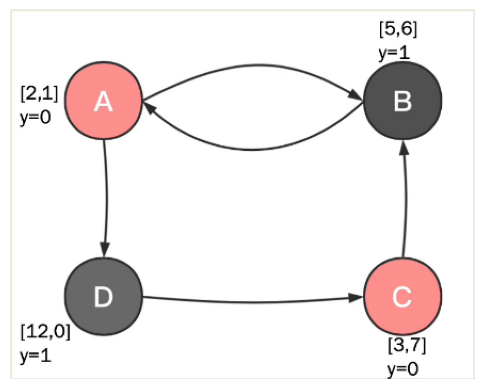

In [29]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg
img1 = mpimg.imread('./images/graph.png')
plt.subplot(111)
plt.imshow(img1)
plt.axis('off')
plt.show()